## Drive Mounting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Category Edgelist Creation

In [ ]:
# Accessing POI metadata
import pandas as pd
POI_metadata = pd.read_csv(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/tucson_poi_metadata.csv')
POI_metadata

,business_id,latitude,longitude,categories
0,-0G_6-KFGpCpxTUlVXCMYQ,32.221294,-110.965698,"Restaurants, Mexican"
1,-1MhPXk1FglglUAmuPLIGg,32.236361,-110.925213,"Nightlife, Burgers, Sports Bars, Bars, Restaur..."
2,-3-6BB10tIWNKGEF0Es2BA,32.288540,-110.963144,"Coffee & Tea, Asian Fusion, Food, Bubble Tea, ..."
3,-8uatt4iWxUproNMOd1srw,32.264597,-110.959955,"Delis, Sandwiches, Comfort Food, Cafes, Restau..."
4,-zH42-1AauJru4EF-s7Rgw,32.223017,-110.908658,"Bars, Restaurants, Nightlife, Latin American, ..."
...,...,...,...,...
1354,ZXhTFMADU3v3hYzXJrz6fw,32.178294,-111.002589,"Chinese, Restaurants"
1355,ZxroTGXXvt_D3KsiAsBIwg,32.248966,-110.971563,"Vietnamese, Restaurants, Food"
1356,ZxymmM8SI80x0VxpW8h9ZQ,32.114822,-110.771707,"Breakfast & Brunch, Restaurants"
1357,ZYxGiEyHD17kd80zUzaOQA,32.264136,-110.944935,"Restaurants, Chinese, Food, Szechuan"


In [ ]:
## Creating list of famous POIs for faster access
poi_list = []
for i in range(len(POI_metadata)):
  poi_list.append(POI_metadata.iloc[i][0])
print(len(poi_list))

1359


In [ ]:
## Forming a dictonary {poi_id:[cat_tag1, cat_tag2....]} for faster access
poi_tags = {}

for poi in poi_list:
  tags = ""
  for tag in list(POI_metadata.loc[POI_metadata['business_id']==poi,'categories'])[0].split(","):
      tag = (tag.strip()).lower()
      tags = tags + " " + tag

  poi_tags[poi] = tags

In [ ]:
## TF-IDF score computation for each tag of POis
from sklearn.feature_extraction.text import TfidfVectorizer

# create a dataframe with the dataset
df = pd.DataFrame.from_dict(poi_tags, orient='index', columns=['keywords'])

# create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# fit the vectorizer on the keywords
tfidf = vectorizer.fit_transform(df['keywords'])


# create a dictionary to store the top 3 keywords for each item
top_keywords = {}

# get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# loop through each item in the dataframe
for i in range(len(poi_tags)):
    # get the TF-IDF score for each keyword in the item's keywords
    item_tfidf = tfidf[i].toarray()[0]
    # create a dictionary with the keyword and its TF-IDF score
    keywords_tfidf = dict(zip(feature_names, item_tfidf))
    # sort the dictionary by the TF-IDF score (descending order)
    sorted_keywords_tfidf = sorted(keywords_tfidf.items(), key=lambda x: x[1], reverse=True)
    # store the top 3 keywords with the highest TF-IDF score for the item in the dictionary
    top_keywords[list(poi_tags.keys())[i]] = [keyword[0] for keyword in sorted_keywords_tfidf[:4] if keyword[0]!= 'restaurants']

In [ ]:
top_keywords

{'-0G_6-KFGpCpxTUlVXCMYQ': ['mexican', 'active', 'african'],
 '-1MhPXk1FglglUAmuPLIGg': ['bars', 'dive', 'soup', 'sports'],
 '-3-6BB10tIWNKGEF0Es2BA': ['tea', 'cafe', 'hong', 'kong'],
 '-8uatt4iWxUproNMOd1srw': ['comfort', 'delis', 'cafes', 'sandwiches'],
 '-zH42-1AauJru4EF-s7Rgw': ['latin', 'nightlife', 'mexican', 'bars'],
 '_2Ge9Kkch69Xi9A0TvucIg': ['bars', 'cocktail', 'breakfast', 'brunch'],
 '_3SfdIE0ac8SXxMktIGVsQ': ['delis', 'salad', 'sandwiches'],
 '_42k0tj-oseoViaTEWb-Dw': ['mexican', 'active', 'african'],
 '_9Z3cuZQBOGv_XzSG4ewHA': ['seafood', 'italian', 'salad', 'pizza'],
 '_b4_ErF9lEE6vePd3lAJgQ': ['soul', 'nightlife', 'bars', 'food'],
 '_c-TzNu-sTCgG_7ggrWEZA': ['dogs', 'hot', 'burgers', 'fast'],
 '_C0IGYgKGWJukyCINJfx5A': ['barbeque', 'caterers', 'event', 'planning'],
 '_CAtatmn5FKtMFXcyQyWdQ': ['food', 'coffee', 'tea', 'burgers'],
 '_hndEVMKrYKcaX24kS5NZA': ['ramen', 'noodles', 'japanese'],
 '_iH5S4hKoEhqeEnoQboSqA': ['desserts', 'pizza', 'sandwiches', 'food'],
 '_iHV--nO

In [ ]:
## Finding Category Occurance Distribution

category_occurances = {}

for poi in top_keywords:
  for category in top_keywords[poi]:
    if category not in category_occurances:
      category_occurances[category] = 0
    category_occurances[category] = category_occurances[category] + 1

occurance_list = list(category_occurances.values())

import pandas as pd
pd.Series(occurance_list).describe()

count    252.000000
mean      19.523810
std       40.049116
min        1.000000
25%        1.000000
50%        4.000000
75%       19.250000
max      325.000000
dtype: float64

In [ ]:
## Counting dominant categories (more than 4 occurances)

count = 0

for category in category_occurances:
  if category_occurances[category] > 4:
    count = count + 1

print("Total Dominant Categories: ",count)

Total Dominant Categories:  121


In [ ]:
## Counting number of POIs covered by dominant categories

covered_pois = 0
flag = 0

for poi in top_keywords:
  for tag in top_keywords[poi]:
    if category_occurances[tag]>4:
      covered_pois = covered_pois + 1
      flag =1
    if flag == 1:
      break

covered_pois

1255

In [ ]:
## Generating edge list with dominant categories

category_edge_list = []

for poi in top_keywords:
  for tag in top_keywords[poi]:
    if category_occurances[tag]>4:
      category_edge_list.append([poi,tag])

In [ ]:
print("Total Edges Introduced by category data: ", len(category_edge_list))

Total Edges Introduced by category data:  4727


In [ ]:
import pickle
with open(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/tucson_category_edges_tf_idf.pkl', 'wb') as f:
    pickle.dump(category_edge_list, f)

## Visited Edgelist Creation




In [ ]:
# Accessing User Reviews
import pandas as pd
Visit_metadata = pd.read_csv(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/tucson_reviews.csv')
Visit_metadata

,review_id,user_id,business_id,stars,text
0,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...
1,UBp0zWyH60Hmw6Fsasei7w,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4,The bun makes the Sonoran Dog. It's like a snu...
2,Jut1KvC3_mW6RGryns_wNQ,0pgYDWcqMiiHUln2JUux3A,6N9T23_iXkcOCh6boAXpIg,3,I will definitely go back and explore the menu...
3,onlgwy5qGDEzddsrnIvtWg,pYXeL0RCqus2IfhthYCOyA,W7NxQw8UYFR0HLPrI08tvw,4,Don't know what it is but If my tummy's feelin...
4,M7h8K7PrLrN8yQb3RhHLdA,CysTz612pTix75Fye6-D4Q,WLiqfxv_GhFFA5sm878a2w,5,Blew $80 on food for the family was worth it f...
...,...,...,...,...,...
154096,KKHdjeQkQbWHnUys7m6cLA,-lg4J2SOILBJOxqH4S0x4g,QpAVPiH1Yujksd_ReL-x-g,5,"Wow, this was one of the best meals I've ever ..."
154097,feNpfoo9wlxYVBG5d0y1mQ,dvu83QWKsnnbGvNVQ3mv7A,GxuxCctcz3Hyk0wnuly7vQ,4,This is now one of two Starbucks in the shoppi...
154098,dkGbETTcSQZTwHSnAMnLUw,_RmG_5kxRPgTWP7RptaFgQ,Bq0CQcwk5R8yhm-MGfHxCA,5,Bosnian food?? \n\n--- location. This is a HID...
154099,YGUyDcnAxZsUAjlK3QF99g,Qa5MBgb7Xyrr9Pg5bD4taQ,jh8j-DWqgWkbRe_a2XtKFQ,5,My secret to finding good food often starts by...


In [ ]:
visited_edges = [] #[user_id : poi_id]

for i in range(len(Visit_metadata)):
  user_id = Visit_metadata.iloc[i,1]
  poi_id = Visit_metadata.iloc[i,2]
  visited_edges.append([user_id, poi_id])

print("Total visited edges :",len(visited_edges))

Total visited edges : 154101


In [ ]:
import pickle
with open(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/visited_edges.pkl', 'wb') as f:
    pickle.dump(visited_edges, f)

## Covisit Edgelist Creation

In [ ]:
## Grouping the userwise visited POIs

userwise_visited_pois = {}
for visit in visited_edges:
  user = visit[0]
  poi = visit[1]
  if user not in userwise_visited_pois:
    userwise_visited_pois[user] = []
  userwise_visited_pois[user].append(poi)

In [ ]:
import tqdm

covisit_edges_directory = {}

for user in tqdm.tqdm(userwise_visited_pois):
  visited_pois = userwise_visited_pois[user]
  for i in range(len(visited_pois)-1):
    head = visited_pois[i]
    for j in range(i+1,len(visited_pois)):
      tail = visited_pois[j]
    if (head,tail) in covisit_edges_directory:
      covisit_edges_directory[(head,tail)] += 1
    elif (tail,head) in covisit_edges_directory:
      covisit_edges_directory[(tail,head)] += 1
    else :
      covisit_edges_directory[(head,tail)] = 1

100%|██████████| 3365/3365 [00:00<00:00, 5254.49it/s]


In [ ]:
import pandas as pd

pd.Series(covisit_edges_directory).describe()

count    118215.000000
mean          1.275100
std           0.845444
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          31.000000
dtype: float64

In [ ]:
significant_covisit_edges = []

for pair in covisit_edges_directory:
  if covisit_edges_directory[pair] > 2:
    temp_list = list(pair)
    significant_covisit_edges.append(temp_list)

print("Total number of covisit edges :", len(significant_covisit_edges))

Total number of covisit edges : 6399


In [ ]:
import pickle
with open(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/poi_covisited_edges.pkl', 'wb') as f:
    pickle.dump(significant_covisit_edges, f)

## Frienship Edgelist Creation

In [ ]:
# Accessing User Friends Data
import pandas as pd
user_fiends_df = pd.read_csv(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/tucson_user_friends.csv')
user_fiends_df

,user_id,friends
0,uVtkixXCP7LXRpC1EedGpA,"iPUviZxhOQoKkWjWdz4DUQ, N5dXuVZ2ofc1Oglk2NSVfA..."
1,gjxv-7WqYy_aK1ZAUreBFg,"_u2EmwQ5USM--vz1X5T5Dg, crgWPc35LxjJccLFVQsQig..."
2,DSDL_v5dvLOIJ-o5sRhz4w,"qxmdrMmjTzgQhyHXKuyy3Q, JbMHLU7HOiNjACKDiZvGfw..."
3,1sGYXSkJHPhJ6wQtc-RbZw,"9w4vI3LRTA4JdJyzOxeEMw, fNSGyM1NJ91CTO_VfJ5asQ..."
4,Qa2NoSc6DphQArihBgY9Gg,"Iqfc_JtaStZwPG66WsBkLg, 6XCZoufB_S-sY6vsxMGd8Q..."
...,...,...
1995,1kB_BhHb6xzeA_Z5-XJRPw,"irWMoDxbQ2aLA9tVP51Z5Q, CWvNKauOJqFyGwCzLQEDGw"
1996,OQaneFUkS1rJJvqfUzjb6g,None
1997,S83Z7vaJykxhOzImWDO__g,None
1998,NkMEXcaG_BgCmPoEi6o-3A,None


In [ ]:
import tqdm

friend_pairs = []
for i in tqdm.tqdm(range(len(user_fiends_df))):
  user1 = user_fiends_df.iloc[i,0]
  for user2 in user_fiends_df.iloc[i,1].split(","):
    user2 = user2.strip()
    friend_pair = [user1,user2]
    #if friend_pair not in friend_pairs:
    friend_pairs.append(friend_pair)

100%|██████████| 2000/2000 [00:00<00:00, 2554.89it/s]


In [ ]:
len(friend_pairs)

194510

In [ ]:
friendcount_dict = {}  #To compute number of friends each user is connected with
for pair in friend_pairs:
  friend_user = pair[1]
  if friend_user not in friendcount_dict:
    friendcount_dict[friend_user] = 0
  friendcount_dict[friend_user] += 1

In [ ]:
import pandas as pd
pd.Series(friendcount_dict).describe()

count    133699.000000
mean          1.454835
std           3.517424
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         667.000000
dtype: float64

In [ ]:
significant_friend_edges = []
for pair in friend_pairs:
  if friendcount_dict[pair[1]] > 4:
    significant_friend_edges.append(pair)

print("Number of edges by friendship connection :",len(significant_friend_edges))

Number of edges by friendship connection : 40577


In [ ]:
import pickle
with open(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/friendship_edges.pkl', 'wb') as f:
    pickle.dump(significant_friend_edges, f)

## POI Geolocation Edgelist Creation

In [ ]:
# Accessing POI metadata
import pandas as pd
POI_metadata = pd.read_csv(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/tucson_poi_metadata.csv')
POI_metadata

,business_id,latitude,longitude,categories
0,-0G_6-KFGpCpxTUlVXCMYQ,32.221294,-110.965698,"Restaurants, Mexican"
1,-1MhPXk1FglglUAmuPLIGg,32.236361,-110.925213,"Nightlife, Burgers, Sports Bars, Bars, Restaur..."
2,-3-6BB10tIWNKGEF0Es2BA,32.288540,-110.963144,"Coffee & Tea, Asian Fusion, Food, Bubble Tea, ..."
3,-8uatt4iWxUproNMOd1srw,32.264597,-110.959955,"Delis, Sandwiches, Comfort Food, Cafes, Restau..."
4,-zH42-1AauJru4EF-s7Rgw,32.223017,-110.908658,"Bars, Restaurants, Nightlife, Latin American, ..."
...,...,...,...,...
1354,ZXhTFMADU3v3hYzXJrz6fw,32.178294,-111.002589,"Chinese, Restaurants"
1355,ZxroTGXXvt_D3KsiAsBIwg,32.248966,-110.971563,"Vietnamese, Restaurants, Food"
1356,ZxymmM8SI80x0VxpW8h9ZQ,32.114822,-110.771707,"Breakfast & Brunch, Restaurants"
1357,ZYxGiEyHD17kd80zUzaOQA,32.264136,-110.944935,"Restaurants, Chinese, Food, Szechuan"


In [ ]:
## Normalizing Geo Values

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Normalize the 'y' column
POI_metadata['lati_normalized'] = scaler.fit_transform(POI_metadata[['latitude']])
POI_metadata['longi_normalized'] = scaler.fit_transform(POI_metadata[['longitude']])

POI_metadata

,business_id,latitude,longitude,categories,lati_normalized,longi_normalized
0,-0G_6-KFGpCpxTUlVXCMYQ,32.221294,-110.965698,"Restaurants, Mexican",0.334307,0.453820
1,-1MhPXk1FglglUAmuPLIGg,32.236361,-110.925213,"Nightlife, Burgers, Sports Bars, Bars, Restaur...",0.370180,0.526468
2,-3-6BB10tIWNKGEF0Es2BA,32.288540,-110.963144,"Coffee & Tea, Asian Fusion, Food, Bubble Tea, ...",0.494412,0.458403
3,-8uatt4iWxUproNMOd1srw,32.264597,-110.959955,"Delis, Sandwiches, Comfort Food, Cafes, Restau...",0.437405,0.464127
4,-zH42-1AauJru4EF-s7Rgw,32.223017,-110.908658,"Bars, Restaurants, Nightlife, Latin American, ...",0.338411,0.556176
...,...,...,...,...,...,...
1354,ZXhTFMADU3v3hYzXJrz6fw,32.178294,-111.002589,"Chinese, Restaurants",0.231930,0.387621
1355,ZxroTGXXvt_D3KsiAsBIwg,32.248966,-110.971563,"Vietnamese, Restaurants, Food",0.400191,0.443296
1356,ZxymmM8SI80x0VxpW8h9ZQ,32.114822,-110.771707,"Breakfast & Brunch, Restaurants",0.080813,0.801928
1357,ZYxGiEyHD17kd80zUzaOQA,32.264136,-110.944935,"Restaurants, Chinese, Food, Szechuan",0.436310,0.491078


In [ ]:
## Creating list of coordinates

co_ord_list = []

for i in range(len(POI_metadata)):
  lati = POI_metadata.iloc[i,4]
  longi = POI_metadata.iloc[i,5]
  co_ord_list.append([lati,longi])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

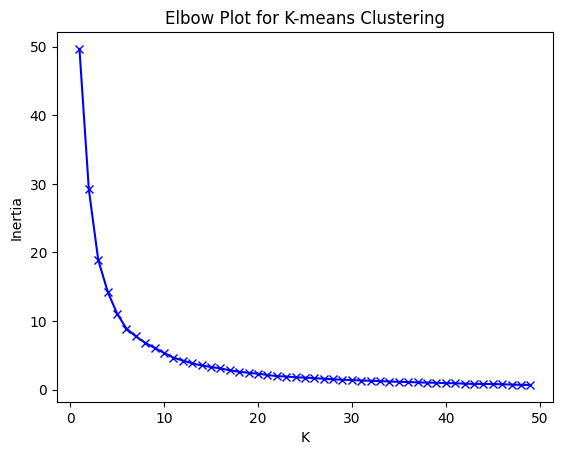

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generate a random 2D list data
data =np.array(co_ord_list)

# Define a range of K values
K_range = range(1, 50)

# Calculate the inertia (sum of squared distances) for each K value
inertia = []
for k in K_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Elbow Plot for K-means Clustering')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


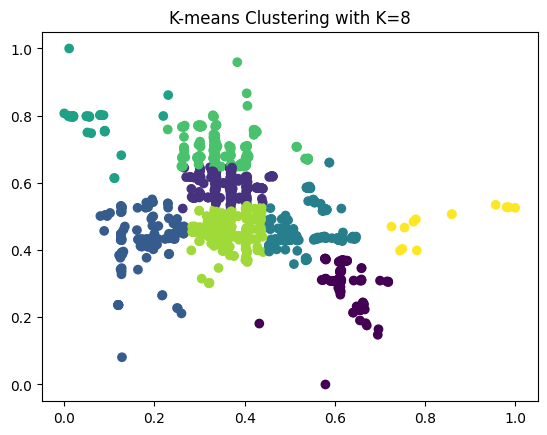

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Generate a random 2D list data
data =np.array(co_ord_list)

kmeans = KMeans(n_clusters=8)
kmeans.fit(data)
labels = kmeans.predict(data)

# Plot the clusters
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.title('K-means Clustering with K=8')
plt.show()

In [ ]:
## generating edge list for geo data

geo_edge_list = []

for i in range(len(POI_metadata)):
  poi = POI_metadata.iloc[i,0]
  cluster_tag = labels[i]
  geo_edge_list.append([poi,cluster_tag])

In [ ]:
import pickle
with open(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/poi_geocluster_edges.pkl', 'wb') as f:
    pickle.dump(geo_edge_list, f)

## User Homecluster Edgelist Generation

In [ ]:
## Constructing POI geocluster dictonary for easy access

poi_geocluster_dict ={}
for edge in geo_edge_list:
  poi_geocluster_dict[edge[0]] = edge[1]

In [ ]:
# Accessing User Reviews
import pandas as pd
Visit_metadata = pd.read_csv(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/tucson_reviews.csv')
Visit_metadata

,review_id,user_id,business_id,stars,text
0,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...
1,UBp0zWyH60Hmw6Fsasei7w,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4,The bun makes the Sonoran Dog. It's like a snu...
2,Jut1KvC3_mW6RGryns_wNQ,0pgYDWcqMiiHUln2JUux3A,6N9T23_iXkcOCh6boAXpIg,3,I will definitely go back and explore the menu...
3,onlgwy5qGDEzddsrnIvtWg,pYXeL0RCqus2IfhthYCOyA,W7NxQw8UYFR0HLPrI08tvw,4,Don't know what it is but If my tummy's feelin...
4,M7h8K7PrLrN8yQb3RhHLdA,CysTz612pTix75Fye6-D4Q,WLiqfxv_GhFFA5sm878a2w,5,Blew $80 on food for the family was worth it f...
...,...,...,...,...,...
154096,KKHdjeQkQbWHnUys7m6cLA,-lg4J2SOILBJOxqH4S0x4g,QpAVPiH1Yujksd_ReL-x-g,5,"Wow, this was one of the best meals I've ever ..."
154097,feNpfoo9wlxYVBG5d0y1mQ,dvu83QWKsnnbGvNVQ3mv7A,GxuxCctcz3Hyk0wnuly7vQ,4,This is now one of two Starbucks in the shoppi...
154098,dkGbETTcSQZTwHSnAMnLUw,_RmG_5kxRPgTWP7RptaFgQ,Bq0CQcwk5R8yhm-MGfHxCA,5,Bosnian food?? \n\n--- location. This is a HID...
154099,YGUyDcnAxZsUAjlK3QF99g,Qa5MBgb7Xyrr9Pg5bD4taQ,jh8j-DWqgWkbRe_a2XtKFQ,5,My secret to finding good food often starts by...


In [ ]:
## Creating Userwise visited cluster dictonary {userid:[c1,c1,c2,c4,c5]}
import tqdm

user_clustervisit_dict = {}
for i in tqdm.tqdm(range(len(Visit_metadata))):
  user = Visit_metadata.iloc[i,1]
  poi =  Visit_metadata.iloc[i,2]
  if poi in poi_geocluster_dict:
    poi_cluster = poi_geocluster_dict[poi]
    if user not in user_clustervisit_dict:
      user_clustervisit_dict[user]=[]
    user_clustervisit_dict[user].append(poi_cluster)

100%|██████████| 154101/154101 [00:09<00:00, 15939.88it/s]


In [ ]:
## Creating homecluster dictonary of user

import statistics

user_home_clusters_edges = []
cluster_home_occurance_dict = {}

for user in user_clustervisit_dict:
  visited_clusters = user_clustervisit_dict[user]
  home_cluster = statistics.mode(visited_clusters)
  user_home_clusters_edges.append([user,home_cluster])
  if home_cluster not in cluster_home_occurance_dict:
    cluster_home_occurance_dict[home_cluster] = 0
  cluster_home_occurance_dict[home_cluster] += 1

In [ ]:
cluster_home_occurance_dict

{2: 75, 6: 1766, 5: 465, 1: 397, 0: 146, 3: 467, 7: 5, 4: 44}

In [ ]:
import pickle
with open(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/user_homegeocluster_edges.pkl', 'wb') as f:
    pickle.dump(user_home_clusters_edges, f)

## POI Aspect Edgelist Creation

In [ ]:
# Accessing User Reviews
import pandas as pd
Visit_metadata = pd.read_csv(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/tucson_reviews.csv')
Visit_metadata

,review_id,user_id,business_id,stars,text
0,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...
1,UBp0zWyH60Hmw6Fsasei7w,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4,The bun makes the Sonoran Dog. It's like a snu...
2,Jut1KvC3_mW6RGryns_wNQ,0pgYDWcqMiiHUln2JUux3A,6N9T23_iXkcOCh6boAXpIg,3,I will definitely go back and explore the menu...
3,onlgwy5qGDEzddsrnIvtWg,pYXeL0RCqus2IfhthYCOyA,W7NxQw8UYFR0HLPrI08tvw,4,Don't know what it is but If my tummy's feelin...
4,M7h8K7PrLrN8yQb3RhHLdA,CysTz612pTix75Fye6-D4Q,WLiqfxv_GhFFA5sm878a2w,5,Blew $80 on food for the family was worth it f...
...,...,...,...,...,...
154096,KKHdjeQkQbWHnUys7m6cLA,-lg4J2SOILBJOxqH4S0x4g,QpAVPiH1Yujksd_ReL-x-g,5,"Wow, this was one of the best meals I've ever ..."
154097,feNpfoo9wlxYVBG5d0y1mQ,dvu83QWKsnnbGvNVQ3mv7A,GxuxCctcz3Hyk0wnuly7vQ,4,This is now one of two Starbucks in the shoppi...
154098,dkGbETTcSQZTwHSnAMnLUw,_RmG_5kxRPgTWP7RptaFgQ,Bq0CQcwk5R8yhm-MGfHxCA,5,Bosnian food?? \n\n--- location. This is a HID...
154099,YGUyDcnAxZsUAjlK3QF99g,Qa5MBgb7Xyrr9Pg5bD4taQ,jh8j-DWqgWkbRe_a2XtKFQ,5,My secret to finding good food often starts by...


In [ ]:
Visit_metadata.iloc[0,4]

'Family diner. Had the buffet. Eclectic assortment: a large chicken leg, fried jalapeño, tamale, two rolled grape leaves, fresh melon. All good. Lots of Mexican choices there. Also has a menu with breakfast served all day long. Friendly, attentive staff. Good place for a casual relaxed meal with no expectations. Next to the Clarion Hotel.'

In [ ]:
## Generating review list for each POI

poi_review_dict = {}
for i in range(len(Visit_metadata)):
    poi = Visit_metadata.iloc[i,2]
    if poi not in poi_review_dict:
        poi_review_dict[poi] = []
    poi_review_dict[poi].append(str(Visit_metadata.iloc[i,4]))

In [ ]:
## Considering noun phrases from each review as candidate aspects
import tqdm
from textblob import TextBlob
import nltk
nltk.download('brown')
nltk.download('punkt')

for poi in tqdm.tqdm(poi_review_dict):
    candidate_list = []
    for review in poi_review_dict[poi]:
        blob = TextBlob(review)
        noun_phrases = list(blob.noun_phrases)
        candidate_list.append(noun_phrases)

    poi_review_dict[poi] = candidate_list

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 14075/14075 [06:51<00:00, 34.22it/s] 


In [ ]:
poi_review_dict

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
## Getting wordcount of unique keywords
wordcount_dict = {}
for poi in tqdm.tqdm(poi_review_dict):
    for wordlist in poi_review_dict[poi]:
        for word in wordlist:
            if word not in wordcount_dict:
                wordcount_dict[word] = 0
            wordcount_dict[word] += 1

100%|██████████| 14075/14075 [00:01<00:00, 8748.68it/s]


In [ ]:
wordcount_dict

{'family diner': 4,
 'eclectic': 74,
 'large chicken leg': 1,
 'grape leaves': 77,
 'fresh melon': 2,
 'lots': 1864,
 'mexican choices': 7,
 'friendly': 1337,
 'attentive staff': 85,
 'good place': 1205,
 'clarion': 4,
 'located': 368,
 'starr pass blvd': 2,
 'kettle': 6,
 'various cities': 6,
 'exceptional service': 68,
 'lady server': 2,
 'extra food': 13,
 'native country': 2,
 'jordan': 52,
 'jordanian': 12,
 'going': 229,
 'hot food': 127,
 'cold food': 86,
 'middle eastern food': 49,
 'regular american food menu': 1,
 'say': 66,
 'ice cream': 2521,
 'gem show ...': 1,
 'pretty hard work': 1,
 'foreign country ....': 1,
 'food places': 23,
 'strawberry': 94,
 'az': 748,
 'cute things': 17,
 'pepsi': 141,
 'overall': 5422,
 'decent respite': 1,
 'i-10/22nd/congress': 1,
 'breakfast buffet': 67,
 'good variety': 276,
 'hash browns': 660,
 'hard instances': 1,
 'avoid': 258,
 'quality food': 168,
 'prologue': 8,
 'way home': 359,
 'holiday weekend': 27,
 'rv': 114,
 'good reviews': 2

In [ ]:
import pandas as pd
pd.Series(list(wordcount_dict.values())).describe()

count    422318.000000
mean          3.718852
std          54.635623
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       26260.000000
dtype: float64

In [ ]:
## Getting list of significant review words for each POI
significant_word_list = []
for word in wordcount_dict:
    if wordcount_dict[word] > 50:
        significant_word_list.append(word)

In [ ]:
len(significant_word_list)

3558

In [ ]:
## Creating [POI,Significant Aspect] edges
poi_significant_aspec_edges = []
for poi in tqdm.tqdm(poi_review_dict):
  for wordlist in poi_review_dict[poi]:
    for word in wordlist:
      if wordcount_dict[word] > 50:
        poi_significant_aspec_edges.append([poi,word])

100%|██████████| 14075/14075 [00:05<00:00, 2643.75it/s]


In [ ]:
len(poi_significant_aspec_edges)

683578

In [ ]:
import pickle
with open(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/poi_significant_aspect_edges.pkl', 'wb') as f:
    pickle.dump(poi_significant_aspec_edges, f)

In [2]:
import pickle
with open(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/poi_significant_aspect_edges.pkl', 'rb') as f:
    has_aspect_edges = pickle.load(f)

In [4]:
## POI aspect dictonary creation for faster access
import tqdm
poi_aspect_dict = {}
for edge in tqdm.tqdm(has_aspect_edges):
  poi = edge[0]
  if poi not in poi_aspect_dict:
    poi_aspect_dict[poi] = []
  poi_aspect_dict[poi].append(edge[1])

100%|██████████| 683578/683578 [00:00<00:00, 850860.36it/s]


In [3]:
# Accessing POI metadata
import pandas as pd
POI_metadata = pd.read_csv(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/tucson_poi_metadata.csv')
POI_metadata

,business_id,latitude,longitude,categories
0,-0G_6-KFGpCpxTUlVXCMYQ,32.221294,-110.965698,"Restaurants, Mexican"
1,-1MhPXk1FglglUAmuPLIGg,32.236361,-110.925213,"Nightlife, Burgers, Sports Bars, Bars, Restaur..."
2,-3-6BB10tIWNKGEF0Es2BA,32.288540,-110.963144,"Coffee & Tea, Asian Fusion, Food, Bubble Tea, ..."
3,-8uatt4iWxUproNMOd1srw,32.264597,-110.959955,"Delis, Sandwiches, Comfort Food, Cafes, Restau..."
4,-zH42-1AauJru4EF-s7Rgw,32.223017,-110.908658,"Bars, Restaurants, Nightlife, Latin American, ..."
...,...,...,...,...
1354,ZXhTFMADU3v3hYzXJrz6fw,32.178294,-111.002589,"Chinese, Restaurants"
1355,ZxroTGXXvt_D3KsiAsBIwg,32.248966,-110.971563,"Vietnamese, Restaurants, Food"
1356,ZxymmM8SI80x0VxpW8h9ZQ,32.114822,-110.771707,"Breakfast & Brunch, Restaurants"
1357,ZYxGiEyHD17kd80zUzaOQA,32.264136,-110.944935,"Restaurants, Chinese, Food, Szechuan"


In [7]:
shortlisted_poi_aspect_dict = {}
for i in range(len(POI_metadata)):
  poi = POI_metadata.iloc[i,0]
  if poi in poi_aspect_dict:
    shortlisted_poi_aspect_dict[poi] =poi_aspect_dict[poi]

In [8]:
len(shortlisted_poi_aspect_dict)

1359

In [9]:
## Creating [POI,Significant Aspect] edges
shortlisted_poi_significant_aspec_edges = []
for poi in tqdm.tqdm(shortlisted_poi_aspect_dict):
  for word in shortlisted_poi_aspect_dict[poi]:
        shortlisted_poi_significant_aspec_edges.append([poi,word])

100%|██████████| 1359/1359 [00:01<00:00, 1355.21it/s]


In [10]:
len(shortlisted_poi_significant_aspec_edges)

414100

In [11]:
import pickle
with open(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/shortlisted_poi_significant_aspect_edges.pkl', 'wb') as f:
    pickle.dump(shortlisted_poi_significant_aspec_edges, f)

## User Significant Aspect Edgelist Creation

In [ ]:
## Generating review list for each User

user_review_dict = {}
for i in range(len(Visit_metadata)):
    user = Visit_metadata.iloc[i,1]
    if user not in user_review_dict:
        user_review_dict[user] = []
    user_review_dict[user].append(str(Visit_metadata.iloc[i,4]))

In [ ]:
## Considering noun phrases from each review as candidate aspects
import tqdm
from textblob import TextBlob
import nltk
nltk.download('brown')
nltk.download('punkt')

for user in tqdm.tqdm(user_review_dict):
    candidate_list = []
    for review in user_review_dict[user]:
        blob = TextBlob(review)
        noun_phrases = list(blob.noun_phrases)
        candidate_list.append(noun_phrases)

    user_review_dict[user] = candidate_list

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 3365/3365 [07:40<00:00,  7.31it/s]


In [ ]:
## Creating [User,Significant Aspect] edges
user_significant_aspec_edges = []
for user in tqdm.tqdm(user_review_dict):
  for wordlist in user_review_dict[user]:
    for word in wordlist:
      if wordcount_dict[word] > 50:
        user_significant_aspec_edges.append([user,word])

100%|██████████| 3365/3365 [00:04<00:00, 801.12it/s]


In [ ]:
user_significant_aspec_edges

[['8g_iMtfSiwikVnbP2etR0A', 'eclectic'],
 ['8g_iMtfSiwikVnbP2etR0A', 'grape leaves'],
 ['8g_iMtfSiwikVnbP2etR0A', 'lots'],
 ['8g_iMtfSiwikVnbP2etR0A', 'friendly'],
 ['8g_iMtfSiwikVnbP2etR0A', 'attentive staff'],
 ['8g_iMtfSiwikVnbP2etR0A', 'good place'],
 ['8g_iMtfSiwikVnbP2etR0A', 'started'],
 ['8g_iMtfSiwikVnbP2etR0A', 'enjoyed'],
 ['8g_iMtfSiwikVnbP2etR0A', 'rice noodles'],
 ['8g_iMtfSiwikVnbP2etR0A', 'breakfast'],
 ['8g_iMtfSiwikVnbP2etR0A', 'busy place'],
 ['8g_iMtfSiwikVnbP2etR0A', 'seems'],
 ['8g_iMtfSiwikVnbP2etR0A', 'table service'],
 ['8g_iMtfSiwikVnbP2etR0A', 'drove'],
 ['8g_iMtfSiwikVnbP2etR0A', 'january'],
 ['8g_iMtfSiwikVnbP2etR0A', 'nice ambiance'],
 ['8g_iMtfSiwikVnbP2etR0A', 'tvs'],
 ['8g_iMtfSiwikVnbP2etR0A', 'arizona'],
 ['8g_iMtfSiwikVnbP2etR0A', 'bummer'],
 ['8g_iMtfSiwikVnbP2etR0A', 'updated'],
 ['8g_iMtfSiwikVnbP2etR0A', 'red wine'],
 ['8g_iMtfSiwikVnbP2etR0A', 'different'],
 ['8g_iMtfSiwikVnbP2etR0A', 'oracle'],
 ['8g_iMtfSiwikVnbP2etR0A', 'yelp'],
 ['8g_iMtfSiw

In [ ]:
import pickle
with open(r'/content/drive/My Drive/GRS_For_POI_Experiments/Post_WITS/Tucson City Data/user_significant_aspect_edges.pkl', 'wb') as f:
    pickle.dump(user_significant_aspec_edges, f)